In [10]:
import cesium
import numpy as np
import scipy
import pandas as pd
import warnings
import tarfile
import os
import time
import shutil
import joblib
from collections import defaultdict
from random import shuffle
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
from supersmoother import SuperSmoother
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from cesium.data_management import parse_and_store_ts_data
from cesium.features import GENERAL_FEATS, LOMB_SCARGLE_FEATS, CADENCE_FEATS
from cesium import featurize
from cesium.time_series import load as load_time_series 

import seaborn as sns; sns.set()
%matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 13.0)

In [3]:
def plot_data_4x4(t, m, e, period, plot_title=None):
    fig, ax = plt.subplots(2)
    fig.subplots_adjust(hspace=0.25)
    fig.suptitle(plot_title, fontsize=14, fontweight='bold')

    # Original ASAS LC
    t_folded = t % period

    # Plot original ASAS data
    ax[0].errorbar(t, m, e, fmt='.')
    ax[0].set_xlabel('t')
    ax[0].set_title('Raw LC')

    # Plot period-folded ASAS data
    ax[1].errorbar(t_folded, m, e, fmt='.')
    ax[1].set_xlabel('phase')
    ax[1].set_title('Period-folded')

    # Generate smoothed curves for the above
    t_smooth = np.linspace(np.min(t), np.max(t), 1000)
    t_smooth_folded = np.linspace(0, period, 1000)
    m_fit = SuperSmoother(period=period).fit(t, m, e).predict(t_smooth)
    m_fit_folded = SuperSmoother(period=period).fit(t_folded, m, e).predict(t_smooth_folded)

    # Plot smoothed curves over ASAS data
    #ax[0].plot(t_smooth, m_fit, '-k', lw=1) # ugly
    ax[1].plot(t_smooth_folded, m_fit_folded, '-k', lw=1)
            
    return ax

In [4]:
header_path = '../../catalina/catalina_header_ASAS_classes.dat'
tarball_path = '../../catalina/cat_lcs_for_test.tar.gz'

In [5]:
ts_paths = parse_and_store_ts_data(data_path=tarball_path, header_path=header_path, output_dir='/tmp',
                                   cleanup_archive=False, cleanup_header=False)

/Users/acrellin/projects/cesium/cesium/data_management.py:39: UserWarning: loadtxt: Empty input file: "/var/folders/tv/qj16g7qs2pjgpm2y4_rgcmp80000j7/T/tmp1v98_0ox/./cat_lcs_for_test.tar.gz"
  ts_data = np.loadtxt(filepath, delimiter=sep, ndmin=2)


ValueError: Incomplete or improperly formatted time series data file provided.

In [38]:
labels = [load_time_series(p).label for p in ts_paths]

{'RR_Lyrae_DM', 'Beta_Persei', 'Beta_Lyrae', 'RS_CVn', 'Classical_Cepheid', 'RR_Lyrae_FM', 'Delta_Scuti', 'RR_Lyrae_FO'}
/tmp/3019021001365.npz
RR_Lyrae_FM
           fname       label
0  3057001012326  Rotational
1  3029001005060  Rotational
2  3025002005197  Rotational
3  3041002022608  Rotational
4  3051002017867  Rotational
2.04832785626


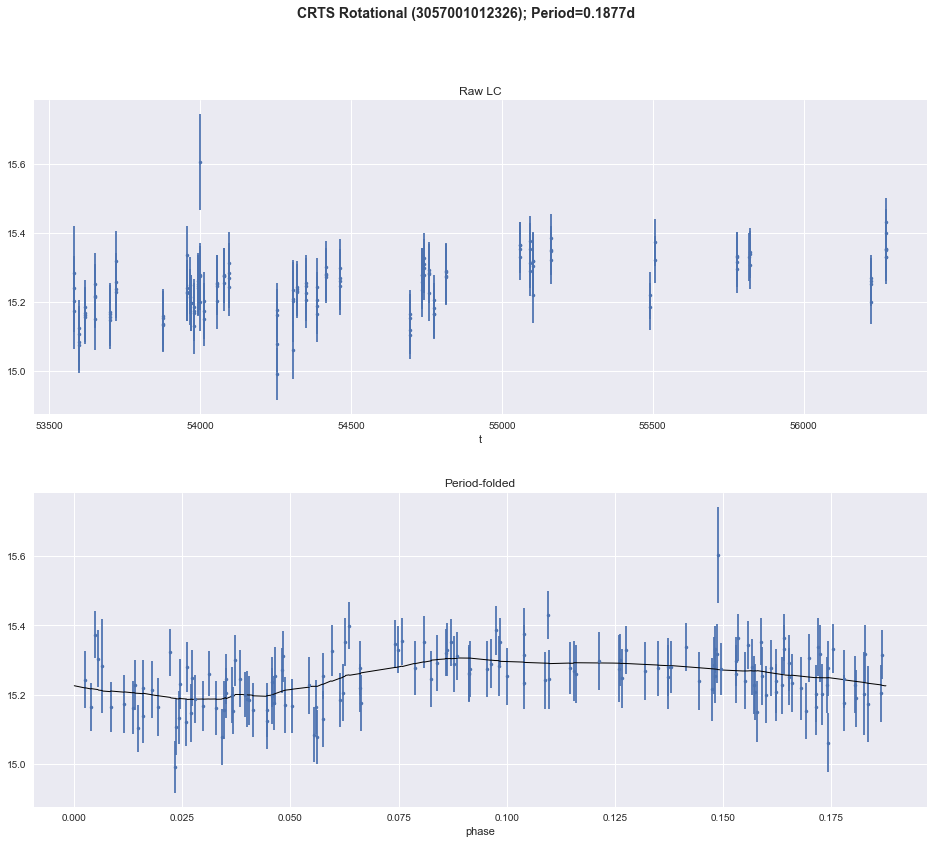

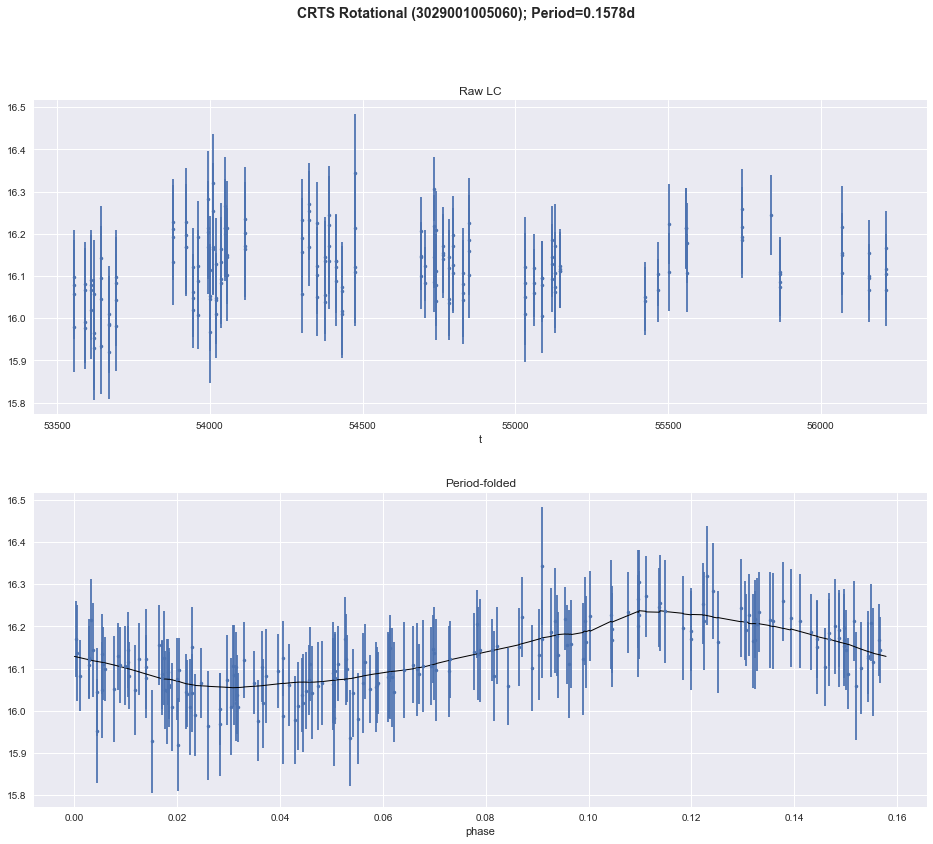

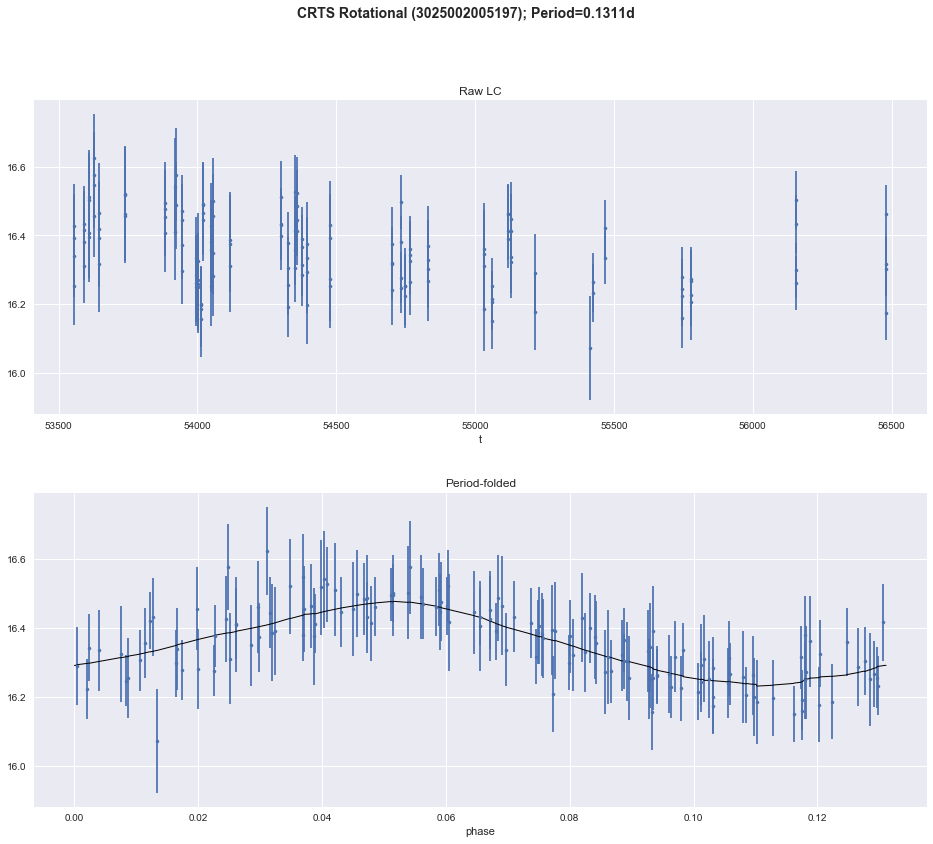

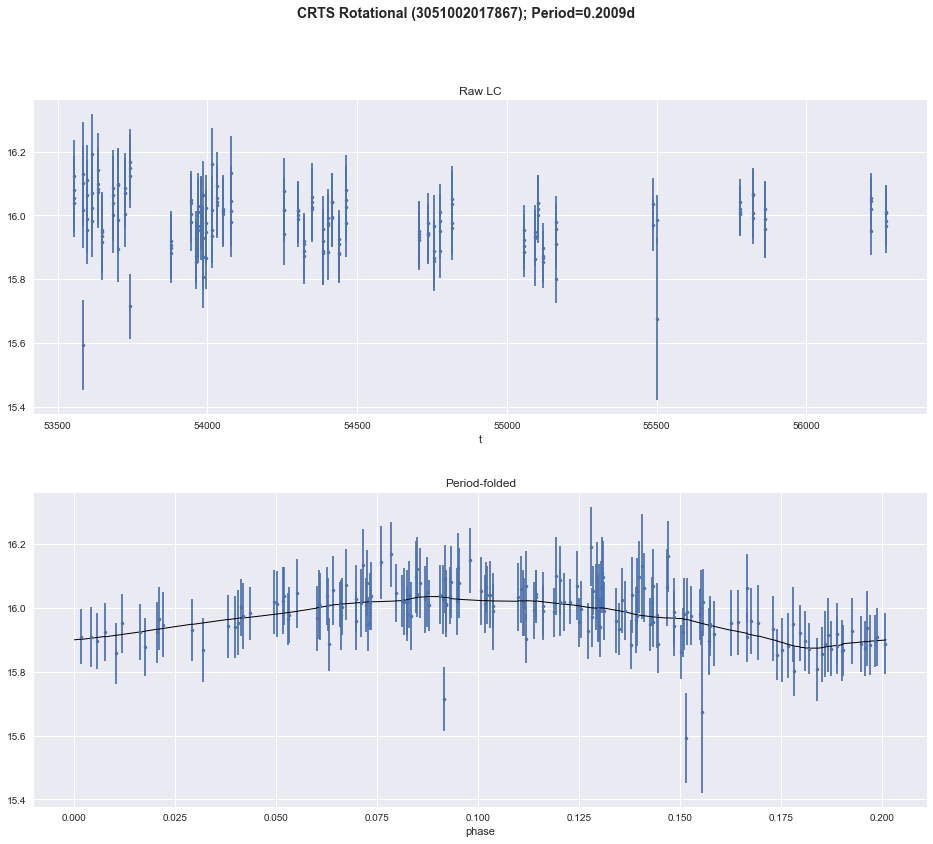

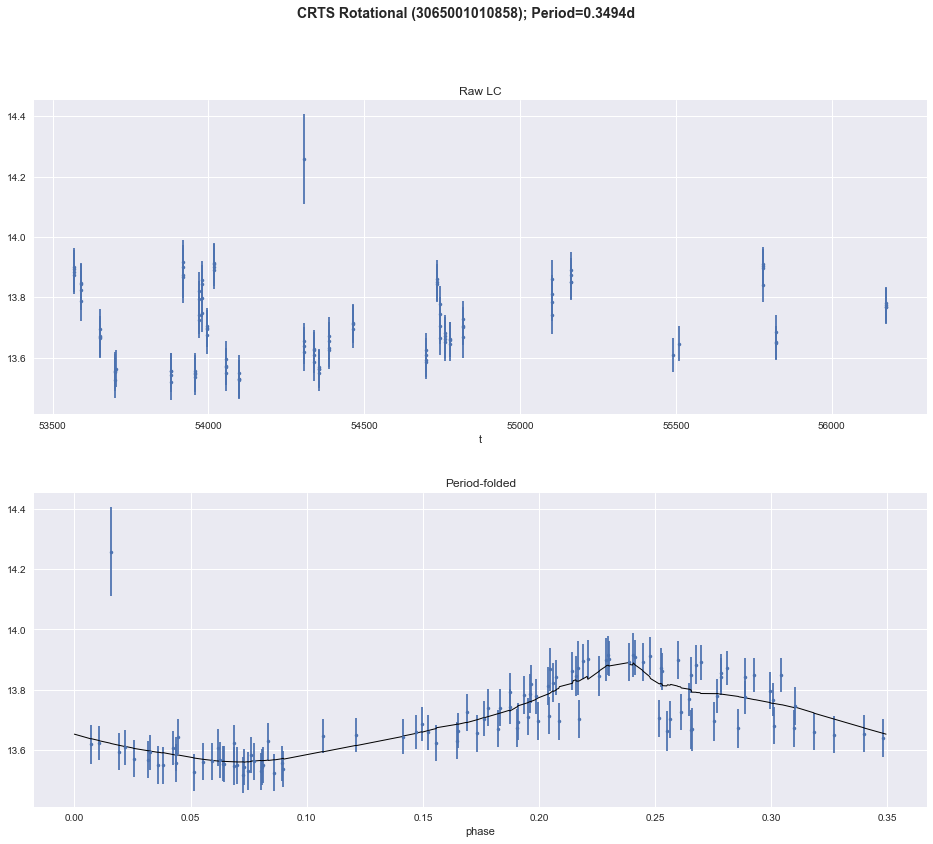

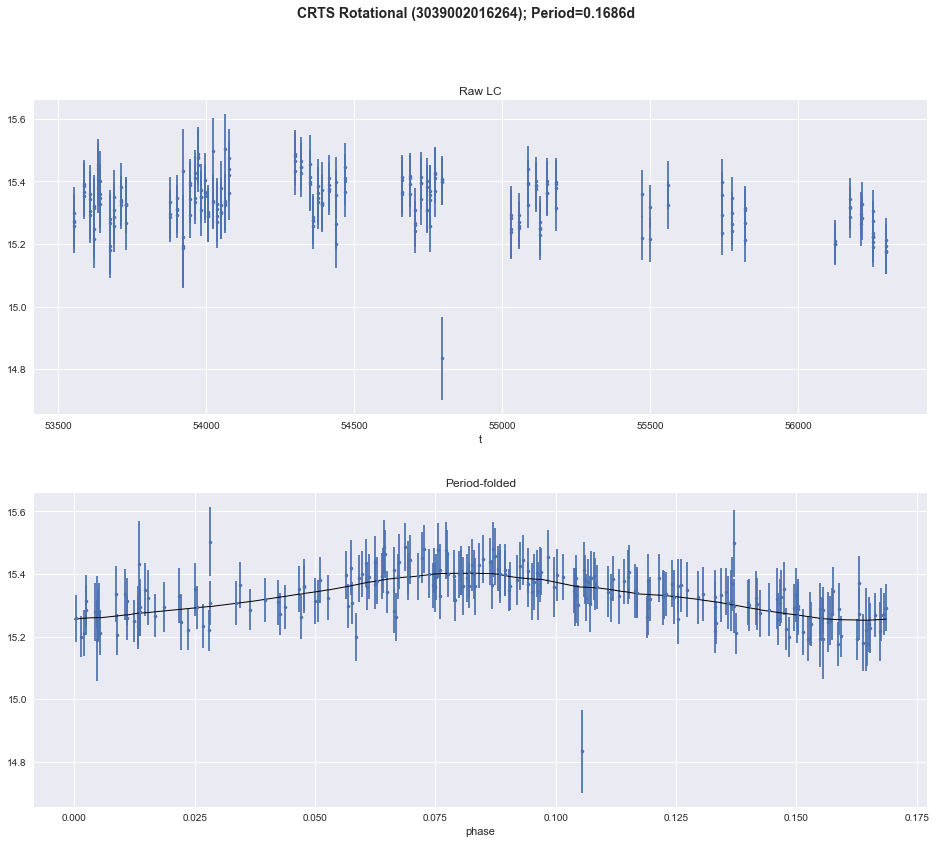

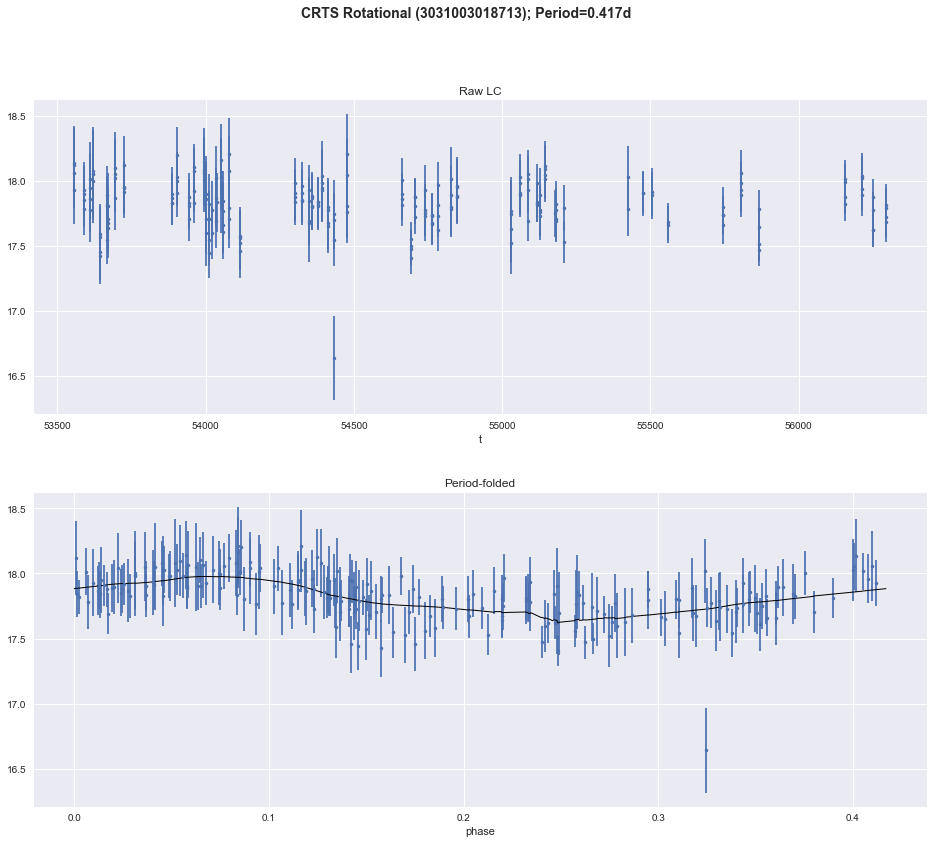

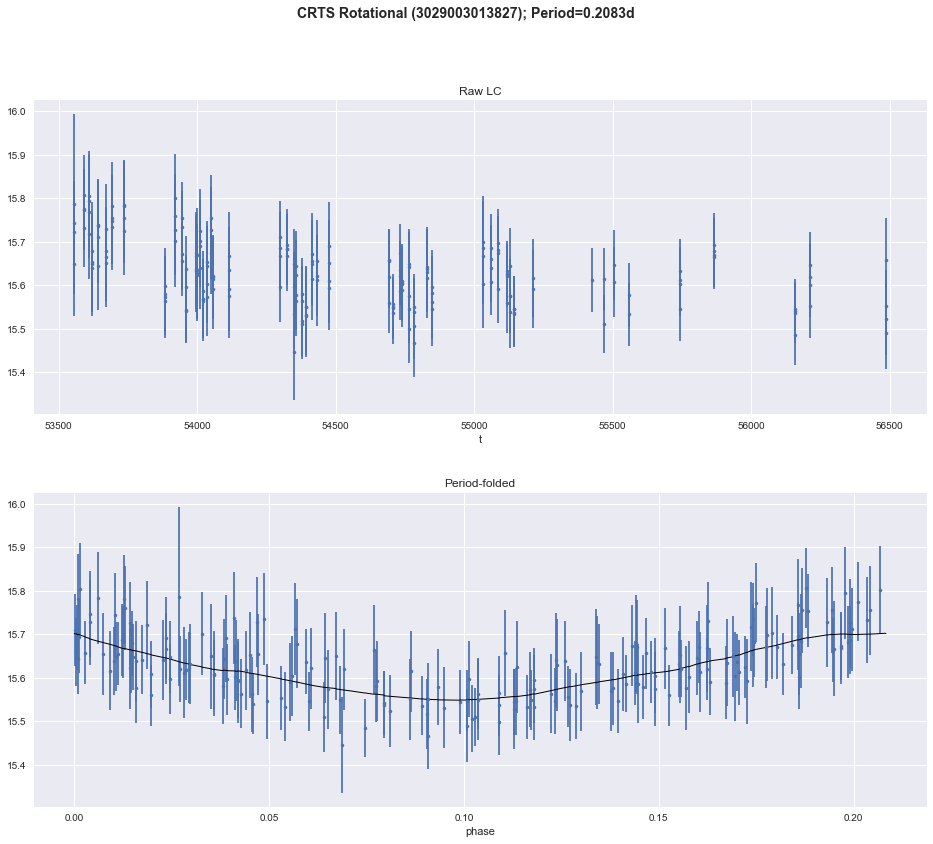

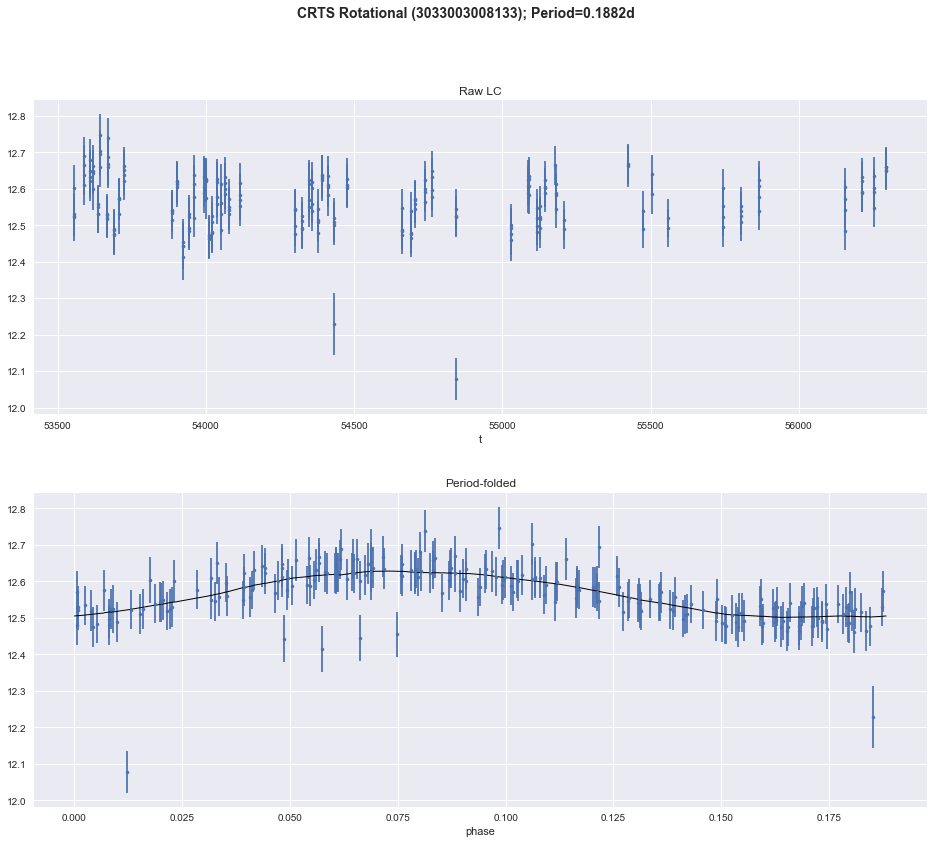

In [85]:
print(set(labels))
print(ts_paths[0])
print(labels[0])

rot_df = pd.read_csv('../../catalina/catalina_header_rotational.dat', header=None)
rot_df.columns = ['fname', 'label']
print(rot_df.head())
rot_df.loc[0]

science_feats, data = featurize.load_featureset('catalina_data/catalina_science_feats.npz')
print(science_feats.loc['3019021001365'].freq1_freq.values[0])

with PdfPages('plots/catalina_rotational_plots.pdf') as pdf:
    for fname in rot_df.fname.values.tolist()[:10]:
        ts = load_time_series(f'/tmp/{fname}.npz')
        period = 1./science_feats.loc[str(fname)].freq1_freq.values[0]
        plot_data_4x4(ts.time, ts.measurement, ts.error, period, plot_title=f'CRTS Rotational ({fname}); Period={round(period, 4)}d')
        
        pdf.savefig()

In [ ]:
import pickle
with open('catalina_ts_paths.pkl', 'wb') as f:
    pickle.dump(ts_paths, f)

In [ ]:
# Ran in terminal:
survey_feats, labels = featurize.featurize_ts_files(ts_paths, features_to_use=CADENCE_FEATS)
survey_feats = featurize.impute_featureset(survey_feats)
featurize.save_featureset(fset=survey_feats, path='catalina_data/catalina_survey_feats.npz', labels=labels)

science_feats, labels = featurize.featurize_ts_files(ts_paths, features_to_use=GENERAL_FEATS + LOMB_SCARGLE_FEATS)
science_feats = featurize.impute_featureset(science_feats)
featurize.save_featureset(fset=science_feats, path='catalina_data/catalina_science_feats.npz', labels=labels)

In [2]:
survey_feats, data = featurize.load_featureset('catalina_data/catalina_survey_feats.npz')
survey_model = joblib.load('../../survey_classifier_data/data/survey_classifier.pkl')
survey_preds = survey_model.predict(survey_feats)
print(np.mean(survey_preds == 'LINEAR'))

1.0


In [6]:
science_feats, data = featurize.load_featureset('catalina_data/catalina_science_feats.npz')
labels = data['labels']

asas_model = joblib.load('data_no_dups_many_asas_new/noisified_ASAS_model_compressed_100.pkl')
asas_model_preds = asas_model.predict(science_feats)
print('ASAS MODEL SCORE:', np.mean(asas_model_preds == labels))

/Users/acrellin/anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/acrellin/anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


ASAS MODEL SCORE: 0.237809662594


In [11]:
w_ursae_labels = labels.copy()
w_ursae_labels[np.argwhere(labels == 'Beta_Lyrae')] = 'W_Ursae_Maj'
w_ursae_labels[np.argwhere(labels == 'RS_CVn')] = 'Delta_Scuti'
print('ASAS MODEL SCORE:', np.mean(asas_model_preds == w_ursae_labels))

ASAS MODEL SCORE: 0.666881515525


In [17]:
# Sort labels for confusion mx
conf_labels = sorted(list(set(list(w_ursae_labels) + list(asas_model_preds))))
print(conf_labels)

['Beta_Cephei', 'Beta_Lyrae', 'Beta_Persei', 'ChemPeculiar', 'ClassT_Tauri', 'Classical_Cepheid', 'Delta_Scuti', 'Herbig_AEBE', 'LSP', 'Mira', 'MultiMode_Cepheid', 'PopII_Cepheid', 'Pulsating_Be', 'RCB', 'RR_Lyrae_DM', 'RR_Lyrae_FM', 'RR_Lyrae_FO', 'RSG', 'RS_CVn', 'RV_Tauri', 'SARG_A', 'SARG_B', 'Semireg_PV', 'W_Ursae_Maj', 'Weakline_T_Tauri']


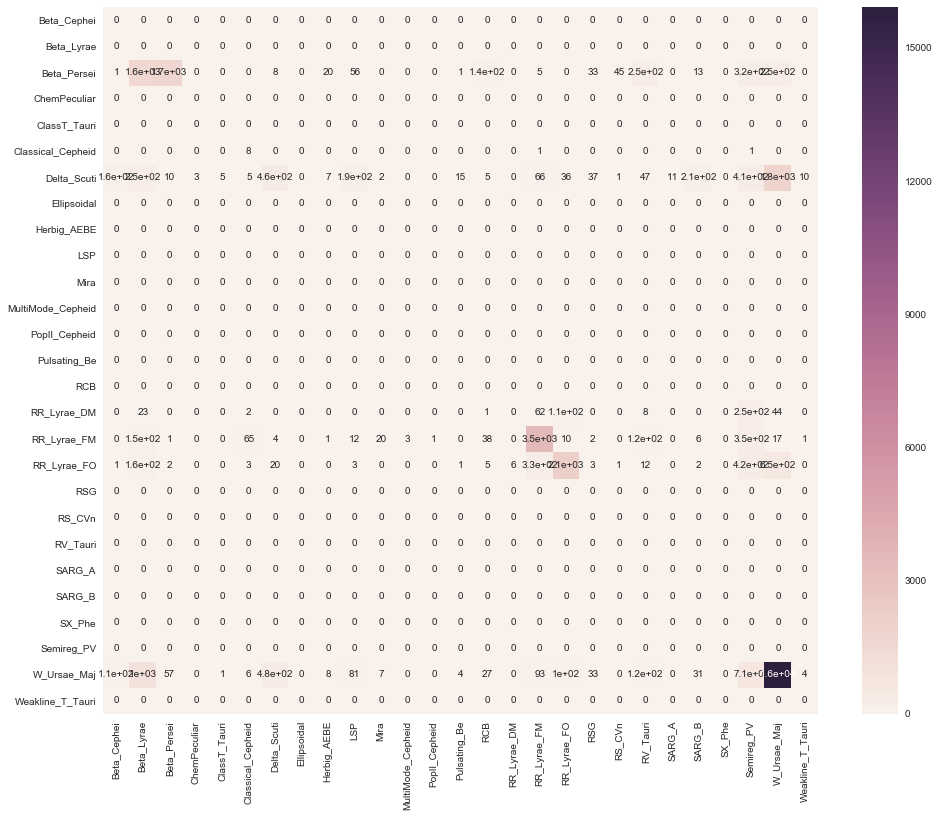

In [24]:
# Plot confusion matrix
conf = confusion_matrix(w_ursae_labels, asas_model_preds, labels=conf_labels)

cm_df = pd.DataFrame(conf, index=conf_labels, columns=conf_labels)

plot = sns.heatmap(cm_df, annot=True)
plot.get_figure().savefig('plots/catalina_variables_asas_model_conf_mx.pdf')

In [13]:
science_feats, data = featurize.load_featureset('catalina_data/catalina_science_feats.npz')
labels = data['labels']

w_ursae_labels = labels.copy()
w_ursae_labels[np.argwhere(labels == 'Beta_Lyrae')] = 'W_Ursae_Maj'
w_ursae_labels[np.argwhere(labels == 'RS_CVn')] = 'Delta_Scuti'


nlcs = []
scores = []
asas_scores = []

for x in ['1', '2', '3', '4', '5', '10', '15', '20', '30', '50', '75', '100']:
    linear_model = joblib.load(f'data_no_dups_many2/noisified_LINEAR_model_optimized_compressed_{x}.pkl')
    linear_model_preds = linear_model.predict(science_feats)
    asas_scores.append(np.mean(linear_model_preds == labels))
    scores.append(np.mean(linear_model_preds == w_ursae_labels))
    nlcs.append(int(x))
    print(x, '-', round(asas_scores[-1], 3), round(scores[-1], 3))
    
scores_df = pd.DataFrame({'num_lcs_used': nlcs, 'score': scores})

1 - 0.266 0.7
2 - 0.288 0.729
3 - 0.308 0.756
4 - 0.309 0.747
5 - 0.306 0.749
10 - 0.308 0.726
15 - 0.298 0.721
20 - 0.309 0.738
30 - 0.311 0.738
50 - 0.315 0.74
75 - 0.314 0.734
100 - 0.316 0.727


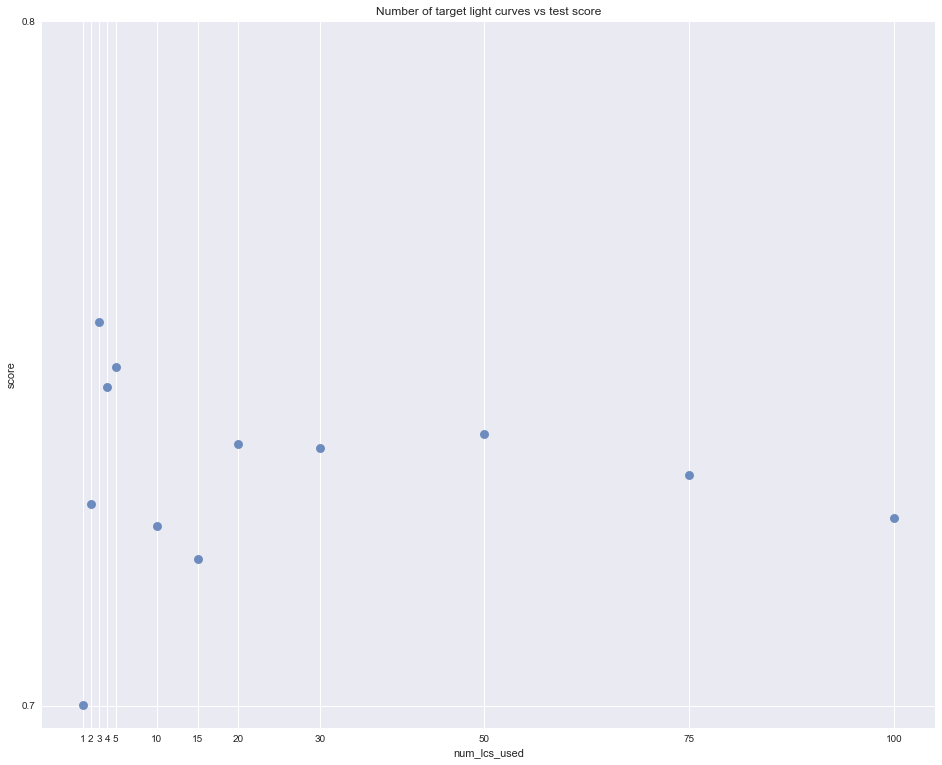

In [21]:
plot = sns.regplot(x='num_lcs_used', y='score', data=scores_df, scatter_kws={"s": 80}, fit_reg=False)
plot.set_yticks([0.7, 0.8])
plot.set_xticks(nlcs)
plot.set_title('Number of target light curves vs test score')
plot.get_figure().savefig('plots/catalina_N_lcs_versus_score.pdf')

In [21]:
# Sort labels for confusion mx
conf_labels = sorted(list(set(list(w_ursae_labels) + list(linear_model_preds))))
print(conf_labels)

['Beta_Cephei', 'Beta_Lyrae', 'Beta_Persei', 'ChemPeculiar', 'ClassT_Tauri', 'Classical_Cepheid', 'Delta_Scuti', 'Ellipsoidal', 'Herbig_AEBE', 'LSP', 'Mira', 'MultiMode_Cepheid', 'PopII_Cepheid', 'Pulsating_Be', 'RCB', 'RR_Lyrae_DM', 'RR_Lyrae_FM', 'RR_Lyrae_FO', 'RSG', 'RS_CVn', 'RV_Tauri', 'SARG_A', 'SARG_B', 'SX_Phe', 'Semireg_PV', 'W_Ursae_Maj', 'Weakline_T_Tauri']


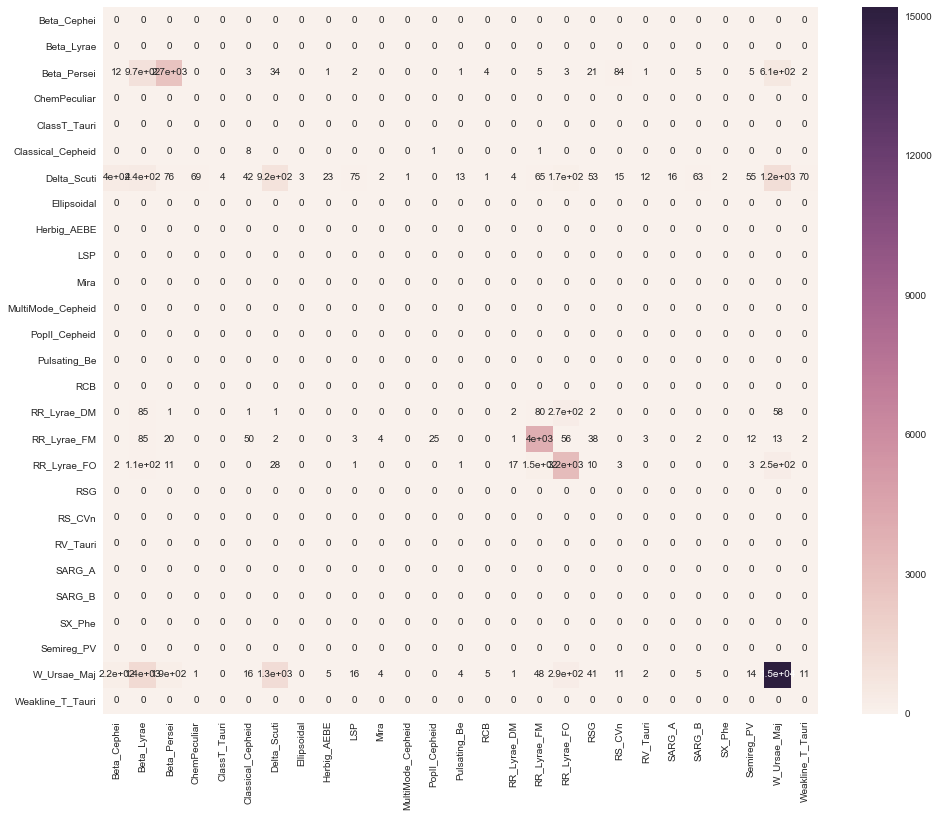

In [25]:
# Plot confusion matrix
conf = confusion_matrix(w_ursae_labels, linear_model_preds, labels=conf_labels)

cm_df = pd.DataFrame(conf, index=conf_labels, columns=conf_labels)

plot = sns.heatmap(cm_df, annot=True)
plot.get_figure().savefig('plots/catalina_variables_linear_model_conf_mx.pdf')